# MPE CDT Summer School on Forecast and Verification



Project 4: Verification of 2 metre temperature (2mt) ensemble seasonal forecasts

Introduction: DEMETER (Development of a European Multimodel Ensemble system for seasonal to
inTERannual prediction) is an EU initiative to develop a well-validated European multi-model
ensemble forecast system for reliable seasonal to inter-annual prediction. It ran from 2000-2003.
(SEE Palmer et al, BAMS, 85, 853-872 for further details of the project, and also on the ECMWF.int
website). This project offers the opportunity to compare the quality of three 9-member ensembles
for three-month average temperature forecasts.

Data files: t2m-ecmwf-JJA-1959-2001.txt, t2m-mf-JJA-1959-2001.txt and
t2m-ukmo-JJA-1959-2001.txt. These files contain 1-month lead 2 metre temperature (2mt) forecasts
produced in May and valid for JJA for the period 1959-2001 (i.e. 43-years of forecasts) for a grid
point in central Pacific (latitude 0 o, longitude 140oW) for three coupled seasonal forecast models
which were included in the DEMETER project (ECMWF, Meteo-France, and UK Met Office).


Goal: To compare and contrast the forecasts from the three models.


In [203]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt


path = '/home/julia/Dropbox/Cursos_Materias/MPE_forecast_verification/MPECDT-ForecastVerification/Project4/'

def open_data(filepath):
    with open(filepath) as f:
        table = pd.read_table(f, sep=' ', index_col=0, header=None,   lineterminator='\n')
        
    return table

def ensemble_mean(data,name):
    mean = np.zeros(len(data[1]))
    for i in range(9):
        mean += data[i+2]
    
    new_data = data
    new_data['ens_mean'] = mean/9
    new_data.columns = ['obs', name+'_1', name+'_2', name+'_3',name+'_4', name+'_5', name+'_6',name+'_7', name+'_8', name+'_9','ens_mean']
    return new_data

def great_ensemble(data_list,name_list):
    df = pd.DataFrame({'obs':data_list[0][1]})
    df.index = data_list[0].index
    for data,name in zip(data_list,name_list):
        new_data = data.copy()
        new_data.columns = ['obs', name+'_1', name+'_2', name+'_3',name+'_4', name+'_5', name+'_6',name+'_7', name+'_8', name+'_9']
        df = df.merge(new_data)
        
    mean = np.zeros(len(df['obs']))
    for i in range(27):
        mean += df.iloc[:,i+1]

    df['ens_mean'] = mean / 27
    return df

def obs_vs_ensmean(data,name):
    fig = plt.figure()
    plt.plot(data['obs'],data['obs'],'--k')
    plt.scatter(data['obs'],data['ens_mean'],marker='o',color='r')
    plt.title(name)
    plt.xlabel('Observations'); plt.ylabel('Forecast')
    return fig



In [204]:
t2m_ecmwf = open_data(path+'data/raw/Proj4_t2m-ecmwf-JJA-1959-2001.txt')
t2m_mf = open_data(path+'data/raw/Proj4_t2m-mf-JJA-1959-2001.txt')
t2m_uk = open_data(path+'data/raw/Proj4_t2m-ukmo-JJA-1959-2001.txt')

data_list = [t2m_ecmwf,t2m_mf,t2m_uk]
name_list = ['ecmwf','mf','uk']

In [205]:
df =  great_ensemble(data_list, name_list)

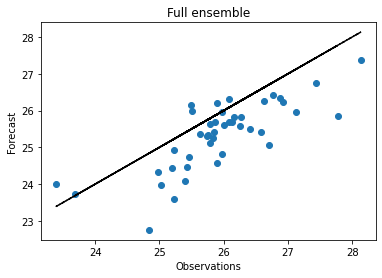

In [207]:
plt.plot(df['obs'],df['obs'],'--k')
plt.scatter(df['obs'],df['ens_mean'])
plt.xlabel('Observations')
plt.ylabel('Forecast')
plt.title('Full ensemble')
plt.savefig(path+'figures/ensamble_bias.png')

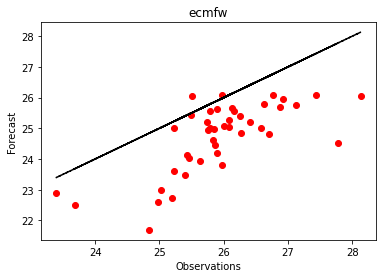

In [208]:
t2m_ecmwf_mean = ensemble_mean(t2m_ecmwf,'ecmwf')
fig = obs_vs_ensmean(t2m_ecmwf_mean,'ecmfw')
fig.savefig(path+'/figures/ecmwf_bias.png')

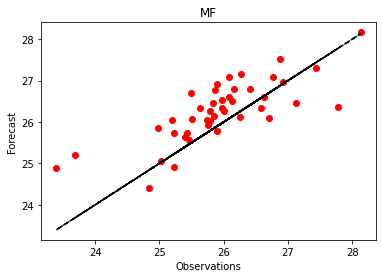

In [209]:
t2m_mf_mean = ensemble_mean(t2m_mf,'mf')
fig = obs_vs_ensmean(t2m_mf_mean,'MF')
fig.savefig(path+'/figures/mf_bias.png')

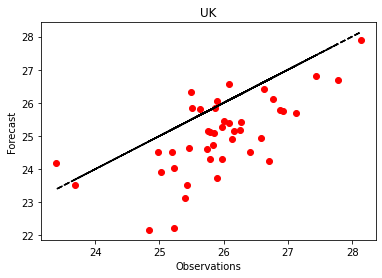

In [210]:
t2m_uk_mean = ensemble_mean(t2m_uk,'ecmwf')
fig = obs_vs_ensmean(t2m_uk_mean,'UK')
fig.savefig(path+'/figures/uk_bias.png')

## Terciles

In [92]:
terciles = df['obs'].quantile([0.33,0.66]).values

In [93]:
np.sum(np.where(df['obs'] >= terciles[1],1,0))/len(df['obs'])

0.3488372093023256

(array([ 2.,  2., 12., 17.,  7.,  3.]),
 array([23.39402852, 24.18343201, 24.97283551, 25.76223901, 26.55164251,
        27.341046  , 28.1304495 ]),
 <BarContainer object of 6 artists>)

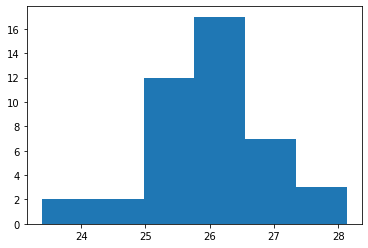

In [87]:
plt.hist(df['obs'],bins = 6)

## Classification of events - contingency table

Below normal, Normal, Above normal

In [235]:
N = 27 #Ensemble members
def categorization_terciles(df,N):
    terciles = df['obs'].quantile([0.33,0.66]).values
    categories = np.where(df['obs'] <= terciles[0],1,0)*(-1) + np.where(df['obs'] >= terciles[1],1,0)
    df['obs_cat'] = categories
    for i in range(N): 
        categories = np.where(df.iloc[:,i+2] <= terciles[0],1,0)*(-1) + np.where(df.iloc[:,i+2] >= terciles[1],1,0)
        df[df.columns[i+2]+'_cat'] = categories
        
    return df
    
def cont_table(obs,sim):
    """Returns a contingency table
    
    
    input: obs, sim must be arrays where -1 indicates below normal (BN), 
                                          1 indicates above normal (AN) and
                                          0 indicates normal (N)
    returns: contingency table with [# (obs AN & forecast AN), # (obs AN & forecast non-AN), #obs AN
                                    # (obs non-AN & forecast AN), # (non-obs AN & forecast non-AN), #obs non-AN]"""
    cont_table = [[np.sum(np.where((obs > 0) & (sim > 0),1,0)),
              np.sum(np.where((obs > 0) & (sim <=0),1,0)),
              np.sum(np.where(obs > 0,1,0))],
              [np.sum(np.where((obs <= 0) & (sim > 0),1,0)),
              np.sum(np.where((obs <= 0) & (sim <= 0),1,0)),
              np.sum(np.where(obs <= 0,1,0))]]
    return np.array(cont_table)

df_cat = categorization_terciles(df,27)
df_uk_cat = categorization_terciles(t2m_uk_mean,9)
df_ecmwf_cat = categorization_terciles(t2m_ecmwf_mean,9)
df_mf_cat = categorization_terciles(t2m_mf_mean,9)
cont_table_ensmean = cont_table(df_cat['obs_cat'],df_cat['ens_mean_cat'])
cont_table_ensmean_mf = cont_table(df_mf_cat['obs_cat'],df_mf_cat['ens_mean_cat'])
cont_table_ensmean_ecmwf = cont_table(df_ecmwf_cat['obs_cat'],df_ecmwf_cat['ens_mean_cat'])
cont_table_ensmean_uk = cont_table(df_uk_cat['obs_cat'],df_uk_cat['ens_mean_cat'])

In [236]:
print('contingency table: ',cont_table_ensmean)
print('hit rate above normal: ' , cont_table_ensmean[0,0]/cont_table_ensmean[0,2])
print('false alarm rate above normal: ' , cont_table_ensmean[0,1]/cont_table_ensmean[0,2])

contingency table:  [[ 6  9 15]
 [ 3 25 28]]
hit rate above normal:  0.4
false alarm rate above normal:  0.6


In [237]:
print('contingency table: ',cont_table_ensmean_mf)
print('hit rate above normal: ' , cont_table_ensmean_mf[0,0]/cont_table_ensmean_mf[0,2])
print('false alarm rate above normal: ' , cont_table_ensmean_mf[0,1]/cont_table_ensmean_mf[0,2])

contingency table:  [[14  1 15]
 [12 16 28]]
hit rate above normal:  0.9333333333333333
false alarm rate above normal:  0.06666666666666667


In [238]:
print('contingency table: ',cont_table_ensmean_uk)
print('hit rate above normal: ' , cont_table_ensmean_uk[0,0]/cont_table_ensmean_uk[0,2])
print('false alarm rate above normal: ' , cont_table_ensmean_uk[0,1]/cont_table_ensmean_uk[0,2])

contingency table:  [[ 5 10 15]
 [ 2 26 28]]
hit rate above normal:  0.3333333333333333
false alarm rate above normal:  0.6666666666666666


In [239]:
print('contingency table: ',cont_table_ensmean_ecmwf)
print('hit rate above normal: ' , cont_table_ensmean_ecmwf[0,0]/cont_table_ensmean_ecmwf[0,2])
print('false alarm rate above normal: ' , cont_table_ensmean_ecmwf[0,1]/cont_table_ensmean_ecmwf[0,2])

contingency table:  [[ 0 15 15]
 [ 0 28 28]]
hit rate above normal:  0.0
false alarm rate above normal:  1.0


In [144]:
cont_table = [[np.sum(np.where((df_cat['obs_cat'] > 0) & (df_cat['mf_1_cat'] > 0),1,0)),
              np.sum(np.where((df_cat['obs_cat'] > 0) & (df_cat['mf_1_cat'] <=0),1,0)),
              np.sum(np.where(df_cat['obs_cat'] > 0,1,0))],
              [np.sum(np.where((df_cat['obs_cat'] <= 0) & (df_cat['mf_1_cat'] > 0),1,0)),
              np.sum(np.where((df_cat['obs_cat'] <= 0) & (df_cat['mf_1_cat'] <= 0),1,0)),
              np.sum(np.where(df_cat['obs_cat'] <= 0,1,0))]]

In [148]:
cont_table = np.array(cont_table)

In [151]:
print('hit rate above normal: ' , cont_table[0,0]/cont_table[0,2])
print('false alarm rate above normal: ' , cont_table[0,1]/cont_table[0,2])

hit rate above normal:  0.9333333333333333
false alarm rate above normal:  0.06666666666666667


## Probabilities of events - ROC curve

For example for the French forecast. 

In [456]:
#The event is still defined as above or below normal considering the terciles, but now it is FORCASTED if it exceeds a threshold
def above_below_normal(data,obs = df_cat['obs'],N=9):
    #Probability of being Temp Above Normal
    AN = np.sum(np.where(data.iloc[:,11:20] > 0,1,0) , axis=1)/N
    #Probability of being Temp Below Normal
    BN = np.sum(np.where(data.iloc[:,11:20] < 0,1,0) , axis=1)/N
    #Probability of being Temp Normal
    Normal = np.sum(np.where(data.iloc[:,11:20] == 0,1,0) , axis=1)/N
    data_prob = pd.DataFrame({'AN':AN,'N':Normal,'BN':BN})
    data_prob['obs'] = obs.values
    return data_prob

N = 9 #Ensemble members
def categorization_threshold(df,N,thresh):
    terciles = df['obs'].quantile([0.33,0.66]).values
    categories = np.where(df['obs'] <= terciles[0],1,0)*(-1) + np.where(df['obs'] >= terciles[1],1,0)
    df['obs_cat'] = categories
    for i in range(N): 
        categories = np.where(df['AN'] < thresh,1,0)*(-1) + np.where(df['AN'] >= thresh,1,0)
        df[str(thresh)] = categories
        
    return df
    
def cont_table(obs,sim):
    """Returns a contingency table
    
    
    input: obs, sim must be arrays where -1 indicates below normal (BN), 
                                          1 indicates above normal (AN) and
                                          0 indicates normal (N)
    returns: contingency table with [# (obs AN & forecast AN), # (obs AN & forecast non-AN), #obs AN
                                    # (obs non-AN & forecast AN), # (non-obs AN & forecast non-AN), #obs non-AN]"""
    cont_table = [[np.sum(np.where((obs > 0) & (sim > 0),1,0)),
              np.sum(np.where((obs > 0) & (sim <=0),1,0)),
              np.sum(np.where(obs > 0,1,0))],
              [np.sum(np.where((obs <= 0) & (sim > 0),1,0)),
              np.sum(np.where((obs <= 0) & (sim <= 0),1,0)),
              np.sum(np.where(obs <= 0,1,0))]]
    return np.array(cont_table)


## MF forecast

In [457]:
df_mf_prob = above_below_normal(df_mf_cat,obs = df_cat['obs'],N=9)

t = 1
n = 9
hit_rate = []; fa_rate = []
bins = np.array([0,1/10,2/10,3/10,4/10,5/10,6/10,7/10,8/10,9/10,1])
for t in bins:
    cats_mf_prob = categorization_threshold(df_mf_prob,n,t)
    cats_mf_prob_table = cont_table(cats_mf_prob['obs_cat'],cats_mf_prob[str(t)])
    hit_rate.append( cats_mf_prob_table[0,0]/(cats_mf_prob_table[0,2]))
    fa_rate.append(cats_mf_prob_table[1,0]/(cats_mf_prob_table[1,2]))
    
print(cats_mf_prob_table)
print('hit rate above normal: ' , cats_mf_prob_table[0,0]/(cats_mf_prob_table[0,2]))
print('false alarm rate above normal: ' , cats_mf_prob_table[1,0]/(cats_mf_prob_table[1,2]))

hit_rate.append(0)
fa_rate.append(0)

[[ 9  6 15]
 [ 0 28 28]]
hit rate above normal:  0.6
false alarm rate above normal:  0.0


### ROC curve

Text(0.5, 1.0, 'ROC curve  - MF forecast - AUC: 0.9023809523809524')

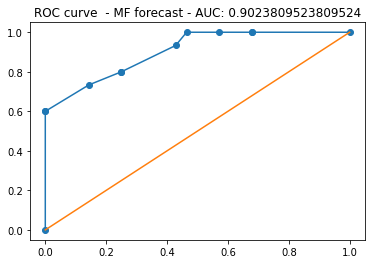

In [460]:
plt.plot(np.array(fa_rate),np.array(hit_rate))
plt.plot(np.array([0,1]),np.array([0,1]))
plt.scatter(np.array(fa_rate),np.array(hit_rate))


integral = 0
for i in range(len(hit_rate)-1):
    suma = (hit_rate[i] + hit_rate[i+1]) * abs(fa_rate[i+1] - fa_rate[i])/2
    integral += suma

plt.title('ROC curve  - MF forecast - AUC: '+ str(integral))

In [451]:
hit_rate

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9333333333333333,
 0.8,
 0.8,
 0.7333333333333333,
 0.6,
 0.6]

In [452]:
fa_rate

[1.0,
 0.6785714285714286,
 0.6785714285714286,
 0.5714285714285714,
 0.4642857142857143,
 0.42857142857142855,
 0.25,
 0.25,
 0.14285714285714285,
 0.0,
 0.0]

## ECMWF forecast

[[ 0 15 15]
 [ 0 28 28]]
hit rate above normal:  [1.0, 1.0, 0.5333333333333333, 0.3333333333333333, 0.2, 0.06666666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0]
false alarm rate above normal:  [1.0, 0.17857142857142858, 0.10714285714285714, 0.03571428571428571, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0]


Text(0.5, 1.0, 'ROC curve  - ECMWF forecast - AUC: 0.9166666666666666')

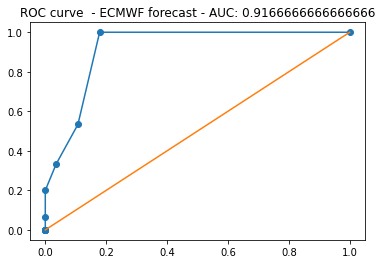

In [463]:
df_ecmwf_prob = above_below_normal(df_ecmwf_cat,obs = df_cat['obs'],N=9)

def roc_curve(df_prob,bins,n):
    hit_rate = []; fa_rate = []
    for t in bins:
        cats_prob = categorization_threshold(df_prob,n,t)
        cats_prob_table = cont_table(cats_prob['obs_cat'],cats_prob[str(t)])
        hit_rate.append( cats_prob_table[0,0]/(cats_prob_table[0,2]))
        fa_rate.append(cats_prob_table[1,0]/(cats_prob_table[1,2]))
    
    return hit_rate,fa_rate,cats_prob_table

n = 9
bins = np.array([0,1/10,2/10,3/10,4/10,5/10,6/10,7/10,8/10,9/10,1])
hit_rate, fa_rate, cats_prob_table = roc_curve(df_ecmwf_prob,bins,n)
hit_rate.append(0)
fa_rate.append(0)

print(cats_prob_table)
print('hit rate above normal: ' , hit_rate)
print('false alarm rate above normal: ' , fa_rate)


plt.plot(np.array(fa_rate),np.array(hit_rate))
plt.plot(np.array([0,1]),np.array([0,1]))
plt.scatter(np.array(fa_rate),np.array(hit_rate))


integral = 0
for i in range(len(hit_rate)-1):
    suma = (hit_rate[i] + hit_rate[i+1]) * abs(fa_rate[i+1] - fa_rate[i])/2
    integral += suma

plt.title('ROC curve  - ECMWF forecast - AUC: '+ str(integral))

## UK Forecast

[[ 2 13 15]
 [ 0 28 28]]
hit rate above normal:  [1.0, 1.0, 0.6666666666666666, 0.4666666666666667, 0.4, 0.26666666666666666, 0.26666666666666666, 0.26666666666666666, 0.26666666666666666, 0.13333333333333333, 0.13333333333333333, 0]
false alarm rate above normal:  [1.0, 0.21428571428571427, 0.17857142857142858, 0.07142857142857142, 0.07142857142857142, 0.07142857142857142, 0.03571428571428571, 0.03571428571428571, 0.0, 0.0, 0.0, 0]


Text(0.5, 1.0, 'ROC curve  - UK forecast - AUC: 0.8952380952380952')

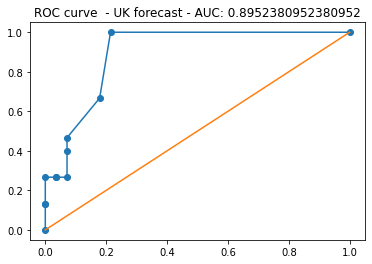

In [464]:
df_uk_prob = above_below_normal(df_uk_cat,obs = df_cat['obs'],N=9)

def roc_curve(df_prob,bins,n):
    hit_rate = []; fa_rate = []
    for t in bins:
        cats_prob = categorization_threshold(df_prob,n,t)
        cats_prob_table = cont_table(cats_prob['obs_cat'],cats_prob[str(t)])
        hit_rate.append( cats_prob_table[0,0]/(cats_prob_table[0,2]))
        fa_rate.append(cats_prob_table[1,0]/(cats_prob_table[1,2]))
    
    return hit_rate,fa_rate,cats_prob_table

n = 9
bins = np.array([0,1/10,2/10,3/10,4/10,5/10,6/10,7/10,8/10,9/10,1])
hit_rate, fa_rate, cats_prob_table = roc_curve(df_uk_prob,bins,n)
hit_rate.append(0)
fa_rate.append(0)

print(cats_prob_table)
print('hit rate above normal: ' , hit_rate)
print('false alarm rate above normal: ' , fa_rate)


plt.plot(np.array(fa_rate),np.array(hit_rate))
plt.plot(np.array([0,1]),np.array([0,1]))
plt.scatter(np.array(fa_rate),np.array(hit_rate))


integral = 0
for i in range(len(hit_rate)-1):
    suma = (hit_rate[i] + hit_rate[i+1]) * abs(fa_rate[i+1] - fa_rate[i])/2
    integral += suma

plt.title('ROC curve  - UK forecast - AUC: '+ str(integral))